<a href="https://colab.research.google.com/github/bcqguo/TimeSeriesAnalysisWithPython/blob/master/Grp_Prj_2_sample_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECON5360 - Group Project 2

## Instruction:

In this assignment, you will work with your group partner to practice an end-to-end forecasting modeling project on crude oil price as "CL=F" in the provided dataset. You will apply at least 2 different algorithms out of the 5 algorithms you learned from this class to forecast the crude oil daily close price. The forecasting period is the 3 last months of the series up to 2023-11-18.  

The dataset will be available directly from the code provided in this notebook. You are free to integrate any other daily related data to the dataset as covariates to improve the forecasting accuracy if you decide to use covariates in your model.

Points: 20 out of 100 of final grade

Delivery Due Date:
1) Project code and slides will be due on <font color='red'>Dec 2nd, 3 days before presentation date on Dec. 2nd</font>. I will comment on your code.
2) Oral presentation will be on <font color='red'>Dec. 6th</font>. during regular class hours on Zoom
3) The revised code after the presentation will be accepted by the end of <font color='red'>Dec 8th</font>.

Grading Scheme:
1) submit your project code and presentation slides on Canvas (10 points)
2) prepare an oral presentation before the class by all teammates (5 points)
3) Q&A and code revision (5 points)

In [2]:
pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import sys, os, pickle, gc, glob
import datetime
import datetime as dt
from tqdm import tqdm
import requests
import json

from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from IPython.display import display, Markdown
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS


In [4]:
# Data Source
try:
    import yfinance as yf
except:
    !pip install -q yfinance
    import yfinance as yf

In [5]:
start_date = "2010-01-01"
end_date = '2023-11-18'

In [6]:
stock_idx = pd.DataFrame(columns = ["Index","Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"])
for i in ['^DJI', '^IXIC', '^GSPC', "CL=F", '^VIX']: # 3 mainstream index plus volatility index and crude oil price
    index_i = yf.download(i,start_date,end_date).reset_index()
    index_i.insert(0, "Index", i)
    stock_idx = pd.concat([stock_idx, index_i])

stock_idx.to_csv('stock_data.csv', index=False)
cl_f_data = stock_idx[stock_idx.Index == "CL=F"]
cl_f_data.to_csv('cl_f_data.csv', index=False)

# Here I'm download a file solely with CL_F data and use it for ARIMA.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
print(stock_idx.shape)
stock_idx[stock_idx.Index == "CL=F"].head(10)

(17468, 8)


,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,CL=F,2010-01-04,79.629997,81.680000,79.629997,81.510002,81.510002,263542
1,CL=F,2010-01-05,81.629997,82.000000,80.949997,81.769997,81.769997,258887
2,CL=F,2010-01-06,81.430000,83.519997,80.849998,83.180000,83.180000,370059
3,CL=F,2010-01-07,83.199997,83.360001,82.260002,82.660004,82.660004,246632
4,CL=F,2010-01-08,82.650002,83.470001,81.800003,82.750000,82.750000,310377
5,CL=F,2010-01-11,82.879997,83.949997,81.959999,82.519997,82.519997,296304
6,CL=F,2010-01-12,82.070000,82.339996,79.910004,80.790001,80.790001,333866
7,CL=F,2010-01-13,80.059998,80.669998,78.370003,79.650002,79.650002,401627
8,CL=F,2010-01-14,79.629997,80.360001,78.919998,79.389999,79.389999,275404
9,CL=F,2010-01-15,79.199997,79.309998,77.699997,78.000000,78.000000,200555


In [8]:
# Pivot the DataFrame to have indices as columns and 'Close' prices as values
pivoted_data = stock_idx.pivot(index='Date', columns='Index', values='Close')

In [9]:
pivoted_data.index[:10] #not continous, with weekend breaks

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [10]:
oil_date = pd.Series(pd.date_range(start=pivoted_data.index.min(), end=pivoted_data.index.max()), name = "Date")

In [11]:
oil_date.index = oil_date

In [12]:
pivoted_data.head()

Index,CL=F,^DJI,^GSPC,^IXIC,^VIX
Date,,,,,
2010-01-04,81.510002,10583.959961,1132.989990,2308.419922,20.040001
2010-01-05,81.769997,10572.019531,1136.520020,2308.709961,19.350000
2010-01-06,83.180000,10573.679688,1137.140015,2301.090088,19.160000
2010-01-07,82.660004,10606.860352,1141.689941,2300.050049,19.059999
2010-01-08,82.750000,10618.190430,1144.979980,2317.169922,18.129999


In [13]:
oil_date.head()

Date
2010-01-04   2010-01-04
2010-01-05   2010-01-05
2010-01-06   2010-01-06
2010-01-07   2010-01-07
2010-01-08   2010-01-08
Name: Date, dtype: datetime64[ns]

In [14]:
oil_input = pd.merge(oil_date, pivoted_data, left_index = True, right_index = True, how = "outer") #it seems oil price is negatively correlated with stock performance

In [15]:
oil_input = oil_input.bfill() #backward fill missing

In [16]:
oil_input.head(10)

,Date,CL=F,^DJI,^GSPC,^IXIC,^VIX
Date,,,,,,
2010-01-04,2010-01-04,81.510002,10583.959961,1132.989990,2308.419922,20.040001
2010-01-05,2010-01-05,81.769997,10572.019531,1136.520020,2308.709961,19.350000
2010-01-06,2010-01-06,83.180000,10573.679688,1137.140015,2301.090088,19.160000
2010-01-07,2010-01-07,82.660004,10606.860352,1141.689941,2300.050049,19.059999
2010-01-08,2010-01-08,82.750000,10618.190430,1144.979980,2317.169922,18.129999
2010-01-09,2010-01-09,82.519997,10663.990234,1146.979980,2312.409912,17.549999
2010-01-10,2010-01-10,82.519997,10663.990234,1146.979980,2312.409912,17.549999
2010-01-11,2010-01-11,82.519997,10663.990234,1146.979980,2312.409912,17.549999
2010-01-12,2010-01-12,80.790001,10627.259766,1136.219971,2282.310059,18.250000


In [17]:
# check missing data
oil_input.isna().sum()

Date     0
CL=F     0
^DJI     0
^GSPC    0
^IXIC    0
^VIX     0
dtype: int64

In [18]:
pickle.dump(oil_input, open("oil_input.pkl", "wb"))

In [19]:
oil_input = pickle.load(open("oil_input.pkl", "rb"))

# For parametric forecasting approach

In [21]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00


In [22]:
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

In [23]:
trn_idx = -90

In [24]:
oil_train = oil_input[:trn_idx]
oil_test = oil_input[trn_idx:]

In [25]:
print(oil_train.shape)
oil_test.shape

(4976, 6)


(90, 6)

In [26]:
#this step takes a while
pqd_fit = auto_arima(oil_train['CL=F'], error_action='ignore', seasonal=True, m=4) #fit daily arima w/ seasonality of 4

In [27]:
pqd_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4976
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 4)   Log Likelihood               -9504.707
Date:                           Fri, 01 Dec 2023   AIC                          19025.414
Time:                                   22:41:23   BIC                          19077.511
Sample:                               01-04-2010   HQIC                         19043.678
                                    - 08-19-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3783      0.049     -7.689      0.000      -0.475      -0.282
ar.L2          0.0052      0.015      0.334      0.738      -0.025       0.035
ar.L3         -0.1765      0.005    -32.594      0.000      -0.187      -0.166
ma.L1          0.3827      0.050      7.619      0.000       0.284       0.481
ar.S.L4        0.5708      0.180      3.178      0.001       0.219       0.923
ar.S.L8        0.0504      0.029      1.724      0.085      -0.007       0.108
ma.S.L4       -0.6898      0.180     -3.832      0.000      -1.043      -0.337
sigma2         2.6728      0.006    465.236      0.000       2.662       2.684
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          23383423.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.44   Skew:                            -6.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       338.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Conclusion: pdq order is SARIMAX(2, 1, 1) adn seasonalith order is (1, 0, 1, 4)

# fit ARIMAX with seasonality

In [ ]:
#convert period index to datetime index
oil_train.index = pd.DatetimeIndex(oil_train.index).to_period('D')

In [ ]:
# fit model w/ seasonality
oil_ARIMA = sm.tsa.SARIMAX(endog = oil_train['CL=F'],
                           order=(3, 1, 1),
                           seasonal_order=(2, 0, 1, 4),
                           freq = "D")

In [ ]:
oil_ARIMA_fit = oil_ARIMA.fit()
oil_ARIMA_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91131D+00    |proj g|=  1.38402D-02


 This problem is unconstrained.



At iterate    5    f=  1.91116D+00    |proj g|=  1.19307D-03

At iterate   10    f=  1.91088D+00    |proj g|=  1.63712D-02

At iterate   15    f=  1.91029D+00    |proj g|=  3.80210D-04

At iterate   20    f=  1.91021D+00    |proj g|=  5.66952D-03

At iterate   25    f=  1.91011D+00    |proj g|=  7.35554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     33      1     0     0   4.839D-05   1.910D+00
  F =   1.9101099012012708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              CL=F   No. Observations:                 4976
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 4)   Log Likelihood               -9504.707
Date:                           Thu, 23 Nov 2023   AIC                          19025.414
Time:                                   14:46:24   BIC                          19077.511
Sample:                               01-04-2010   HQIC                         19043.678
                                    - 08-19-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3783      0.049     -7.689      0.000      -0.475      -0.282
ar.L2          0.0052      0.015      0.334      0.738      -0.025       0.035
ar.L3         -0.1765      0.005    -32.594      0.000      -0.187      -0.166
ma.L1          0.3827      0.050      7.619      0.000       0.284       0.481
ar.S.L4        0.5708      0.180      3.178      0.001       0.219       0.923
ar.S.L8        0.0504      0.029      1.724      0.085      -0.007       0.108
ma.S.L4       -0.6898      0.180     -3.832      0.000      -1.043      -0.337
sigma2         2.6728      0.006    465.236      0.000       2.662       2.684
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          23383423.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.44   Skew:                            -6.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       338.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

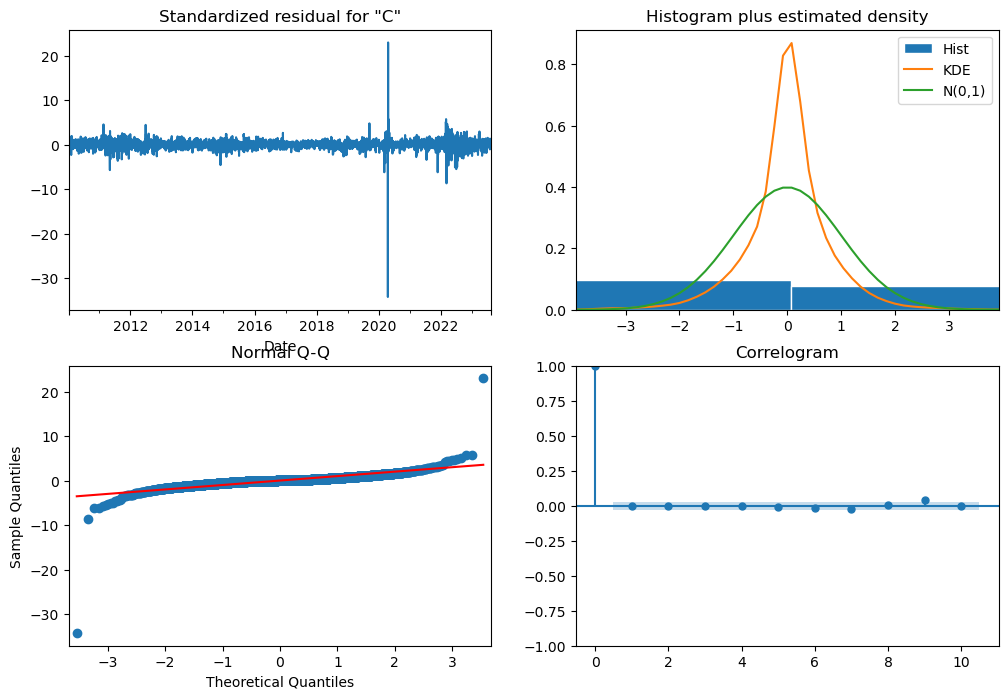

In [ ]:
# Serial Correlation
fig = oil_ARIMA_fit.plot_diagnostics(figsize = (12,8))

In [ ]:
ypred_0 = oil_ARIMA_fit.predict(start = oil_input.index[trn_idx],
                                end = oil_input.index[-1])

In [ ]:
ypred_0_df = pd.DataFrame(ypred_0)

In [ ]:
ypred_0_df.head()

,predicted_mean
2023-08-20,80.619920
2023-08-21,80.432053
2023-08-22,80.498156
2023-08-23,80.571690
2023-08-24,80.624591


In [ ]:
ypred_0_df.index = pd.to_datetime(ypred_0_df.index.to_timestamp())

In [ ]:
oil_pred = pd.merge(ypred_0_df, oil_input[trn_idx:], left_index = True, right_index = True)

In [ ]:
oil_pred.head()

,predicted_mean,Date,CL=F,^DJI,^GSPC,^IXIC,^VIX
2023-08-20,80.619920,2023-08-20,80.720001,34463.691406,4399.770020,13497.589844,17.129999
2023-08-21,80.432053,2023-08-21,80.720001,34463.691406,4399.770020,13497.589844,17.129999
2023-08-22,80.498156,2023-08-22,80.349998,34288.828125,4387.549805,13505.870117,16.969999
2023-08-23,80.571690,2023-08-23,78.889999,34472.980469,4436.009766,13721.030273,15.980000
2023-08-24,80.624591,2023-08-24,79.050003,34099.421875,4376.310059,13463.969727,17.200001


In [ ]:
# mean absolute percentage error, or mean_absolute_percentage_error from sklearn
mape = np.mean(np.abs((oil_pred.predicted_mean/ oil_pred['CL=F']-1))) * 100
print(f"Mean absolute percentage error (MAPE) : {round(mape, 4)}%")

Mean absolute percentage error (MAPE) : 5.9315%


In [ ]:
## Calculate and print the Root Mean Squared Error (RMSE) of the forecast
rmse = mean_squared_error(oil_pred.predicted_mean, oil_pred['CL=F'], squared = False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 6.175054787921658


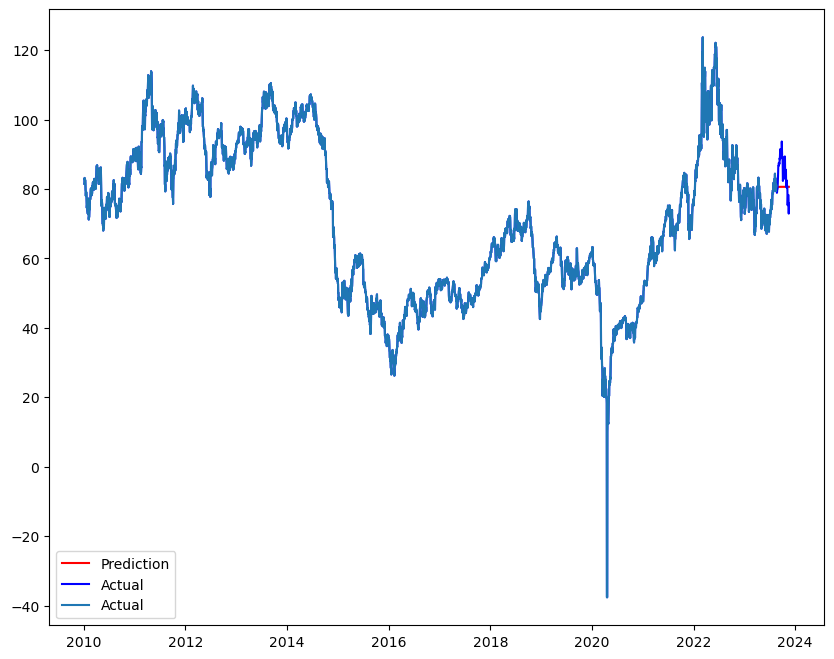

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ypred_0_df, 'r-', label="Prediction")
ax.plot(oil_input['CL=F'], 'b-', label="Actual")
ax.plot(oil_input['CL=F'][:trn_idx], label="Actual")
ax.legend(loc="best")

# Use neuralforecast Approach

In [ ]:
#pip install neuralforecast

In [ ]:
from IPython.display import display, Markdown
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS

In [ ]:
oil_input.head()

,Date,CL=F,^DJI,^GSPC,^IXIC,^VIX
Date,,,,,,
2010-01-04,2010-01-04,81.510002,10583.959961,1132.989990,2308.419922,20.040001
2010-01-05,2010-01-05,81.769997,10572.019531,1136.520020,2308.709961,19.350000
2010-01-06,2010-01-06,83.180000,10573.679688,1137.140015,2301.090088,19.160000
2010-01-07,2010-01-07,82.660004,10606.860352,1141.689941,2300.050049,19.059999
2010-01-08,2010-01-08,82.750000,10618.190430,1144.979980,2317.169922,18.129999


In [ ]:
oil_input_nf = oil_input.rename(columns = {"Date":"ds", "CL=F":"y"})

In [ ]:
oil_input_nf['unique_id'] = "Oil"

In [ ]:
oil_input_nf.set_index("unique_id", inplace = True)

In [ ]:
oil_input_nf.head()

,ds,y,^DJI,^GSPC,^IXIC,^VIX
unique_id,,,,,,
Oil,2010-01-04,81.510002,10583.959961,1132.989990,2308.419922,20.040001
Oil,2010-01-05,81.769997,10572.019531,1136.520020,2308.709961,19.350000
Oil,2010-01-06,83.180000,10573.679688,1137.140015,2301.090088,19.160000
Oil,2010-01-07,82.660004,10606.860352,1141.689941,2300.050049,19.059999
Oil,2010-01-08,82.750000,10618.190430,1144.979980,2317.169922,18.129999


In [ ]:
oil_test_nf = oil_input_nf[trn_idx:]
oil_train_nf = oil_input_nf[:trn_idx]

In [ ]:
pickle.dump((oil_train_nf, oil_test_nf), open("neuralforest_data.pkl", "wb"))

In [ ]:
(oil_train_nf, oil_test_nf) = pickle.load(open("neuralforest_data.pkl", "rb"))

In [ ]:
#use 16 rows of historical data for 8 rows of future forecasting
horizon = len(oil_test_nf)
models = [NBEATS(input_size=8 * horizon, h=horizon, max_steps=100, random_seed=1234),
          NHITS(input_size=8 * horizon, h=horizon, max_steps=100, random_seed=1234)]

Seed set to 1234
Seed set to 1234


In [ ]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=oil_train_nf[['ds','y']])
Y_hat_df = nf.predict().reset_index()

Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

In [ ]:
Y_hat_df = oil_test_nf.merge(Y_hat_df, on=['ds'])
plot_df = pd.concat([oil_train_nf, Y_hat_df]).set_index('ds')

In [ ]:
plot_df.tail()

,y,^DJI,^GSPC,^IXIC,^VIX,unique_id,NBEATS,NHITS
ds,,,,,,,,
2023-11-13,78.260002,34337.871094,4411.549805,13767.740234,14.76,Oil,78.342247,76.713295
2023-11-14,78.260002,34827.699219,4495.700195,14094.379883,14.16,Oil,79.275948,76.536385
2023-11-15,76.660004,34991.210938,4502.879883,14103.839844,14.18,Oil,79.088211,76.755974
2023-11-16,72.900002,34945.468750,4508.240234,14113.669922,14.32,Oil,78.057533,76.691246
2023-11-17,75.889999,34947.281250,4514.020020,14125.480469,13.80,Oil,78.629517,76.760941


In [ ]:
print(f"NBEATS MAPE:{mean_absolute_percentage_error(Y_hat_df.y, Y_hat_df.NBEATS)}") #better, 6.28%
print(f"NHITS MAPE:{mean_absolute_percentage_error(Y_hat_df.y, Y_hat_df.NHITS)}") #

NBEATS MAPE:0.06282045612310036
NHITS MAPE:0.07318933898600864


In [ ]:
print(f"NBEATS RMSE:{mean_squared_error(Y_hat_df.y, Y_hat_df.NBEATS, squared = False)}") #rmse also better
print(f"NHITS RMSE:{mean_squared_error(Y_hat_df.y, Y_hat_df.NHITS, squared = False)}") #

NBEATS RMSE:6.48398243494432
NHITS RMSE:7.511249205260235


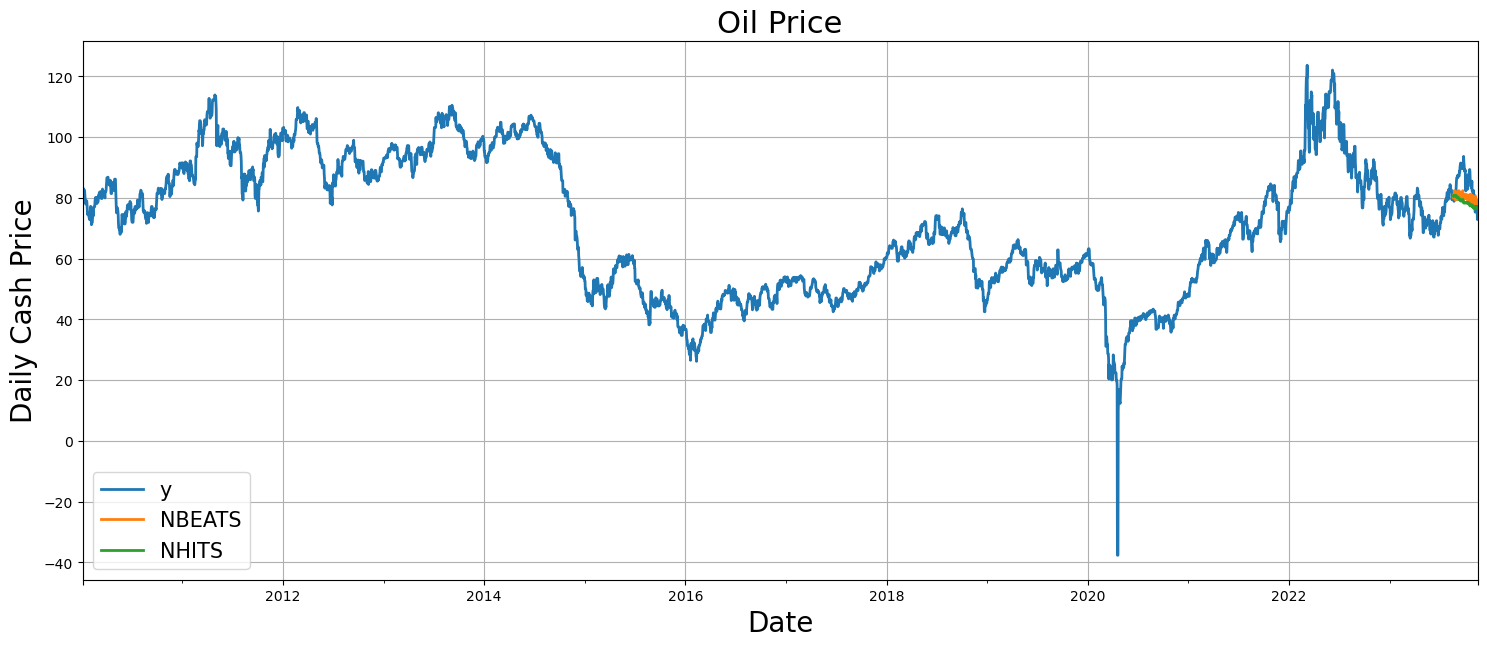

In [ ]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('Oil Price', fontsize=22)
ax.set_ylabel('Daily Cash Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


# pick NBEATS over NHITS

# finetuning NBEATS w/ Optuna

In [ ]:
#pip install optuna

In [ ]:
(oil_train_nf, oil_test_nf) = pickle.load(open("neuralforest_data.pkl", "rb"))

In [ ]:
oil_train_nf.head()

,ds,y,^DJI,^GSPC,^IXIC,^VIX
unique_id,,,,,,
Oil,2010-01-04,81.510002,10583.959961,1132.989990,2308.419922,20.040001
Oil,2010-01-05,81.769997,10572.019531,1136.520020,2308.709961,19.350000
Oil,2010-01-06,83.180000,10573.679688,1137.140015,2301.090088,19.160000
Oil,2010-01-07,82.660004,10606.860352,1141.689941,2300.050049,19.059999
Oil,2010-01-08,82.750000,10618.190430,1144.979980,2317.169922,18.129999


In [ ]:
import optuna

In [ ]:
def objective(trial: optuna.Trial) -> float:
    global oil_train_nf, oil_test_nf #train_adj1, series_adj1_scaled

    param = {
        "input_size": trial.suggest_int("input_size", len(oil_test_nf), len(oil_train_nf), len(oil_test_nf)),
        'max_steps':trial.suggest_int("max_steps", 100, 500, 100),
        #"output_chunk_length": trial.suggest_int("output_chunk_length", 1,8,2),
        'activation':  trial.suggest_categorical('activation',['ReLU', 'LeakyReLU']),
    }

    models = [NBEATS(**param, h=len(oil_test_nf), random_seed=1234)]
    nbeats = NeuralForecast(models=models, freq='D')
    nbeats.fit(oil_train_nf)
    preds = nbeats.predict().reset_index() #,series=train_price, past_covariates=series_adj1_scaled)
    preds = oil_test_nf.merge(preds, how = 'left', on=['ds'])

    #use MAPE to evaluate performance
    accuracy = mean_absolute_percentage_error(np.array(oil_test_nf.y), np.array(preds.NBEATS))

    return accuracy

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=10, timeout=600)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-24 22:18:19,479] A new study created in memory with name: no-name-0c295395-8401-4cb3-b409-7520db1942c8
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:28,535] Trial 0 finished with value: 0.09985634949130652 and parameters: {'input_size': 4590, 'max_steps': 500, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.09985634949130652.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:35,582] Trial 1 finished with value: 0.05531068084915968 and parameters: {'input_size': 270, 'max_steps': 500, 'activation': 'ReLU'}. Best is trial 1 with value: 0.05531068084915968.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:42,281] Trial 2 finished with value: 0.10642920399666424 and parameters: {'input_size': 3780, 'max_steps': 400, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.05531068084915968.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:49,187] Trial 3 finished with value: 0.05260402704134528 and parameters: {'input_size': 900, 'max_steps': 500, 'activation': 'LeakyReLU'}. Best is trial 3 with value: 0.05260402704134528.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:50,896] Trial 4 finished with value: 0.057133926115920115 and parameters: {'input_size': 3780, 'max_steps': 100, 'activation': 'LeakyReLU'}. Best is trial 3 with value: 0.05260402704134528.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:18:57,756] Trial 5 finished with value: 0.06678491626524988 and parameters: {'input_size': 450, 'max_steps': 500, 'activation': 'ReLU'}. Best is trial 3 with value: 0.05260402704134528.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:19:05,012] Trial 6 finished with value: 0.048427436306903396 and parameters: {'input_size': 1080, 'max_steps': 500, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.048427436306903396.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:19:06,641] Trial 7 finished with value: 0.0726178622466234 and parameters: {'input_size': 1530, 'max_steps': 100, 'activation': 'LeakyReLU'}. Best is trial 6 with value: 0.048427436306903396.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:19:09,673] Trial 8 finished with value: 0.12414155149261724 and parameters: {'input_size': 2340, 'max_steps': 200, 'activation': 'ReLU'}. Best is trial 6 with value: 0.048427436306903396.
Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Predicting: |                                                                                   | 0/? [00:00<?…

[I 2023-11-24 22:19:12,760] Trial 9 finished with value: 0.07787289878924926 and parameters: {'input_size': 3960, 'max_steps': 200, 'activation': 'ReLU'}. Best is trial 6 with value: 0.048427436306903396.


Number of finished trials: 10
Best trial:
  Value: 0.048427436306903396
  Params: 
    input_size: 1080
    max_steps: 500
    activation: LeakyReLU


In [ ]:
#parse best parameters
trial.params.items()

dict_items([('input_size', 1080), ('max_steps', 500), ('activation', 'LeakyReLU')])

In [ ]:
#parse best parameters
pickle.dump(trial.params, open("nbeats_para.pkl", "wb"))

In [ ]:
models_bst = [NBEATS(input_size= trial.params['input_size'], h=len(oil_test_nf),
                     max_steps=trial.params['max_steps'],
                     activation = trial.params['activation'],
                     random_seed=1234)]
nbeats = NeuralForecast(models=models_bst, freq='D')
nbeats.fit(oil_train_nf)

Seed set to 1234


Sanity Checking: |                                                                              | 0/? [00:00<?…

Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

In [ ]:
preds = nbeats.predict().reset_index() #,series=train_price, past_covariates=series_adj1_scaled)
preds['ds'] = list(oil_test_nf.ds)
preds = oil_test_nf.merge(preds, how = 'left', on=['unique_id', 'ds'])

Predicting: |                                                                                   | 0/? [00:00<?…

In [ ]:
#NBEATS rmse
nbeats_bst = mean_squared_error(oil_test_nf.y, preds.NBEATS, squared = False)
nbeats_bst

4.897911830633796

In [ ]:
nbeats_mape = mean_absolute_percentage_error(oil_test_nf.y, preds.NBEATS) * 100
nbeats_mape

4.8427436306903395

In [ ]:
plot_nbeats = pd.concat([oil_train_nf, preds]).set_index('ds')[-200:] #plot last 200 days of forecasting

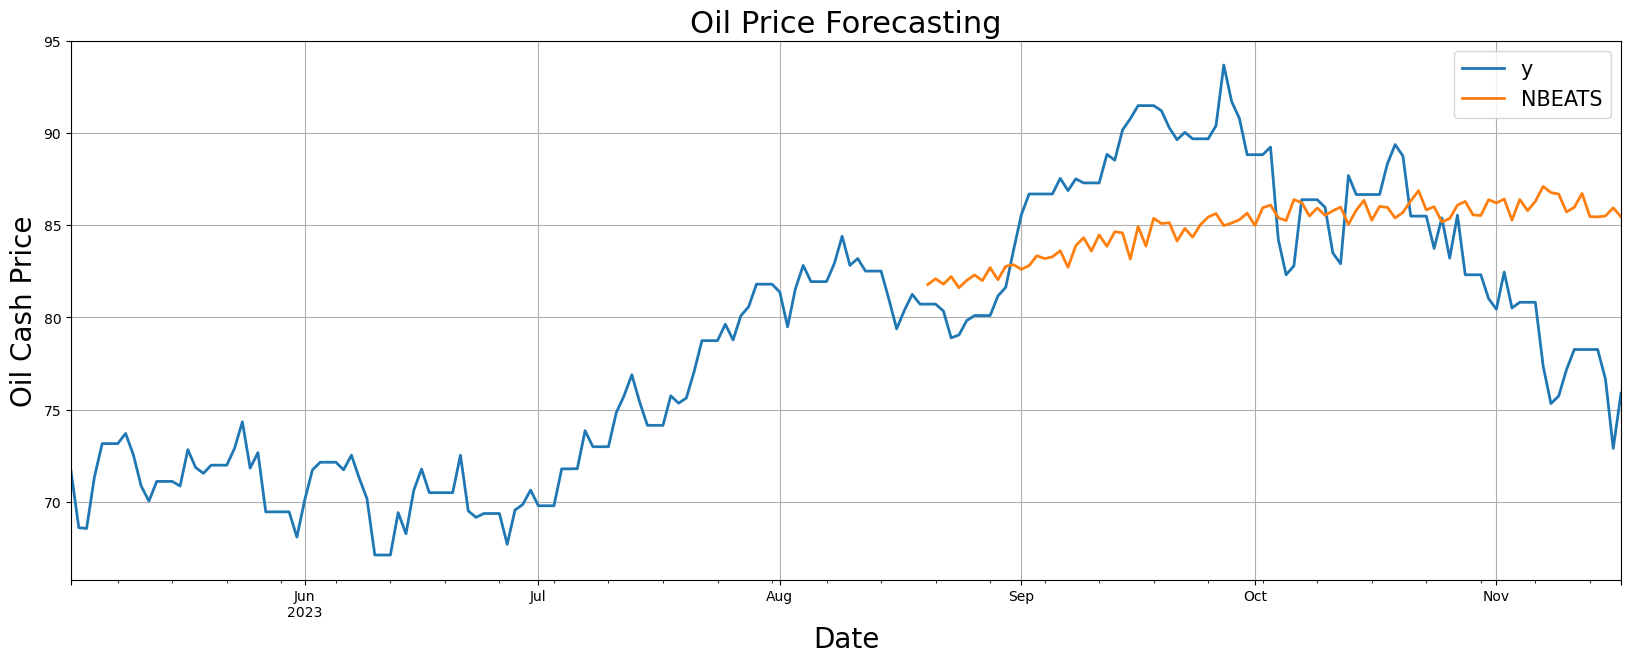

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_nbeats[['y', 'NBEATS']].plot(ax=ax, linewidth=2)
ax.set_title('Oil Price Forecasting', fontsize=22)
ax.set_ylabel('Oil Cash Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# Conclusion: After finetuning with Optuna, the best 3-month forcast model for crude oil cash price is NBEATS with
* input size of 3960 of historical daily data.
* max_steps of 100
* activation function is LeakyReLU

# Inclusion of covariate "^DJI" and "^VIX" model to the NBEATSx model

In [ ]:
from neuralforecast.models import NBEATSx

In [ ]:
hist_exog_list = ['^DJI', "^VIX"]

In [ ]:
def objective(trial: optuna.Trial) -> float:
    global oil_train_nf, oil_test_nf #train_adj1, series_adj1_scaled

    param = {
        "input_size": trial.suggest_int("input_size", len(oil_test_nf), len(oil_train_nf)), #set low, high w/o step
        'max_steps':trial.suggest_int("max_steps", 100, 500, 50),
        #"output_chunk_length": trial.suggest_int("output_chunk_length", 1,8,2),
        "learning_rate": trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    }

    models = [NBEATSx(**param, h=len(oil_test_nf),
                      hist_exog_list = hist_exog_list,
                      #activation = 'LeakyReLU',
                      scaler_type = 'robust',
                      random_seed=1234)]

    nbeats = NeuralForecast(models=models, freq='D')
    nbeats.fit(oil_train_nf)
    preds = nbeats.predict().reset_index() #,series=train_price, past_covariates=series_adj1_scaled)
    preds = oil_test_nf.merge(preds, how = 'left', on=['ds'])
    accuracy = mean_absolute_percentage_error(np.array(oil_test_nf.y), np.array(preds.NBEATSx))

    return accuracy

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, timeout=600)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-01 11:06:36,279] A new study created in memory with name: no-name-62fa2dc7-84b2-470a-b7eb-9b9b150f9c27
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:06:41,006] Trial 0 finished with value: 0.06280920846013634 and parameters: {'input_size': 402, 'max_steps': 300, 'learning_rate': 0.0005969226097775808}. Best is trial 0 with value: 0.06280920846013634.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:06:48,295] Trial 1 finished with value: 0.08161589026177364 and parameters: {'input_size': 400, 'max_steps': 500, 'learning_rate': 0.0009303670714004514}. Best is trial 0 with value: 0.06280920846013634.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:06:56,442] Trial 2 finished with value: 0.07315156314046724 and parameters: {'input_size': 4549, 'max_steps': 250, 'learning_rate': 0.0005586834511869264}. Best is trial 0 with value: 0.06280920846013634.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:09,247] Trial 3 finished with value: 0.06389595106438778 and parameters: {'input_size': 4703, 'max_steps': 400, 'learning_rate': 6.200024663580807e-05}. Best is trial 0 with value: 0.06280920846013634.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:17,131] Trial 4 finished with value: 0.05607498728150003 and parameters: {'input_size': 768, 'max_steps': 500, 'learning_rate': 1.3220321359183564e-05}. Best is trial 4 with value: 0.05607498728150003.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:22,714] Trial 5 finished with value: 0.06475015115882934 and parameters: {'input_size': 2488, 'max_steps': 250, 'learning_rate': 0.00074232472288194}. Best is trial 4 with value: 0.05607498728150003.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:35,675] Trial 6 finished with value: 0.05474797014705073 and parameters: {'input_size': 3294, 'max_steps': 500, 'learning_rate': 9.34544020574467e-05}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:47,170] Trial 7 finished with value: 0.07676186282541742 and parameters: {'input_size': 2419, 'max_steps': 500, 'learning_rate': 0.00010886534768010965}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:07:53,735] Trial 8 finished with value: 0.06008352809927801 and parameters: {'input_size': 3042, 'max_steps': 250, 'learning_rate': 4.44273806970604e-05}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:05,128] Trial 9 finished with value: 0.06020710140429257 and parameters: {'input_size': 3161, 'max_steps': 450, 'learning_rate': 2.1130322719025446e-05}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:07,251] Trial 10 finished with value: 0.0964268705156898 and parameters: {'input_size': 1681, 'max_steps': 100, 'learning_rate': 0.00018566008285758354}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:14,085] Trial 11 finished with value: 0.08709275042709741 and parameters: {'input_size': 1288, 'max_steps': 400, 'learning_rate': 1.0194590350637454e-05}. Best is trial 6 with value: 0.05474797014705073.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:24,816] Trial 12 finished with value: 0.05442086334007467 and parameters: {'input_size': 3842, 'max_steps': 400, 'learning_rate': 2.2598550549700277e-05}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:35,999] Trial 13 finished with value: 0.057072605054586605 and parameters: {'input_size': 4033, 'max_steps': 400, 'learning_rate': 3.4863686579977694e-05}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:45,719] Trial 14 finished with value: 0.06007392646178724 and parameters: {'input_size': 3807, 'max_steps': 350, 'learning_rate': 2.480765834433917e-05}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:08:57,861] Trial 15 finished with value: 0.05572662059081235 and parameters: {'input_size': 3722, 'max_steps': 450, 'learning_rate': 8.204922853705264e-05}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:00,626] Trial 16 finished with value: 0.058663638922014164 and parameters: {'input_size': 3116, 'max_steps': 100, 'learning_rate': 0.00015212062395575038}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:07,359] Trial 17 finished with value: 0.10217211494106715 and parameters: {'input_size': 1809, 'max_steps': 350, 'learning_rate': 5.393496246619338e-05}. Best is trial 12 with value: 0.05442086334007467.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:20,397] Trial 18 finished with value: 0.05425977265275535 and parameters: {'input_size': 4287, 'max_steps': 450, 'learning_rate': 2.7162447408086553e-05}. Best is trial 18 with value: 0.05425977265275535.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:32,226] Trial 19 finished with value: 0.06999003800689278 and parameters: {'input_size': 4926, 'max_steps': 350, 'learning_rate': 1.6158202840800868e-05}. Best is trial 18 with value: 0.05425977265275535.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:46,353] Trial 20 finished with value: 0.05493250682879438 and parameters: {'input_size': 4435, 'max_steps': 450, 'learning_rate': 2.8435954818077835e-05}. Best is trial 18 with value: 0.05425977265275535.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:09:58,593] Trial 21 finished with value: 0.05308763965971786 and parameters: {'input_size': 3559, 'max_steps': 450, 'learning_rate': 1.9235366849886987e-05}. Best is trial 21 with value: 0.05308763965971786.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:11,784] Trial 22 finished with value: 0.06152393027297478 and parameters: {'input_size': 4137, 'max_steps': 450, 'learning_rate': 1.8357945841893865e-05}. Best is trial 21 with value: 0.05308763965971786.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:22,506] Trial 23 finished with value: 0.0604788128800957 and parameters: {'input_size': 3544, 'max_steps': 400, 'learning_rate': 3.39044060569e-05}. Best is trial 21 with value: 0.05308763965971786.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:31,729] Trial 24 finished with value: 0.04887439878355849 and parameters: {'input_size': 4272, 'max_steps': 300, 'learning_rate': 1.0965164310239111e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:36,523] Trial 25 finished with value: 0.06543916831466609 and parameters: {'input_size': 4176, 'max_steps': 150, 'learning_rate': 1.0392842788115961e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:46,134] Trial 26 finished with value: 0.053243584638597845 and parameters: {'input_size': 4376, 'max_steps': 300, 'learning_rate': 1.584456446334504e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:10:56,320] Trial 27 finished with value: 0.0788289827429256 and parameters: {'input_size': 4899, 'max_steps': 300, 'learning_rate': 1.3318550465767768e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:03,213] Trial 28 finished with value: 0.054473031841040125 and parameters: {'input_size': 3487, 'max_steps': 250, 'learning_rate': 1.6297082314572672e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:08,099] Trial 29 finished with value: 0.05630335589781983 and parameters: {'input_size': 2645, 'max_steps': 200, 'learning_rate': 1.0540825461779728e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:15,284] Trial 30 finished with value: 0.05670366875296473 and parameters: {'input_size': 2784, 'max_steps': 300, 'learning_rate': 1.6718523547048008e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:25,811] Trial 31 finished with value: 0.06088912477322096 and parameters: {'input_size': 4400, 'max_steps': 350, 'learning_rate': 2.5618613085104844e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:31,767] Trial 32 finished with value: 0.056682666375771795 and parameters: {'input_size': 4174, 'max_steps': 200, 'learning_rate': 1.3768885851092704e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:41,209] Trial 33 finished with value: 0.0631465753153072 and parameters: {'input_size': 4584, 'max_steps': 300, 'learning_rate': 2.089379882741794e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:47,203] Trial 34 finished with value: 0.054337036529097105 and parameters: {'input_size': 4319, 'max_steps': 200, 'learning_rate': 3.1699623884813544e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:11:58,266] Trial 35 finished with value: 0.062201629240242313 and parameters: {'input_size': 4696, 'max_steps': 350, 'learning_rate': 1.338352703233494e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:07,037] Trial 36 finished with value: 0.05897813618789482 and parameters: {'input_size': 3950, 'max_steps': 300, 'learning_rate': 1.9976255259564323e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:13,857] Trial 37 finished with value: 0.04919415849287406 and parameters: {'input_size': 3645, 'max_steps': 250, 'learning_rate': 4.37355810895206e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:20,490] Trial 38 finished with value: 0.05707784892794024 and parameters: {'input_size': 3617, 'max_steps': 250, 'learning_rate': 3.9744454840011484e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:27,092] Trial 39 finished with value: 0.058046147962893424 and parameters: {'input_size': 3349, 'max_steps': 250, 'learning_rate': 3.904335453388145e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:31,332] Trial 40 finished with value: 0.06970100631339561 and parameters: {'input_size': 2163, 'max_steps': 200, 'learning_rate': 4.5574051609202136e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:46,193] Trial 41 finished with value: 0.061952022868037006 and parameters: {'input_size': 4623, 'max_steps': 500, 'learning_rate': 2.5844659724562095e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:12:54,687] Trial 42 finished with value: 0.052246947730234944 and parameters: {'input_size': 3944, 'max_steps': 300, 'learning_rate': 3.0060531713556614e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:01,956] Trial 43 finished with value: 0.05751053212131393 and parameters: {'input_size': 2859, 'max_steps': 300, 'learning_rate': 1.8001619006452063e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:06,161] Trial 44 finished with value: 0.06668894086290439 and parameters: {'input_size': 665, 'max_steps': 250, 'learning_rate': 2.2030569257797263e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:14,173] Trial 45 finished with value: 0.05615911674222882 and parameters: {'input_size': 3382, 'max_steps': 300, 'learning_rate': 3.124641878997551e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:17,699] Trial 46 finished with value: 0.05201480914831585 and parameters: {'input_size': 90, 'max_steps': 250, 'learning_rate': 1.1997717067190508e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:19,662] Trial 47 finished with value: 0.054450357296727446 and parameters: {'input_size': 211, 'max_steps': 150, 'learning_rate': 1.2218090249339491e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:24,323] Trial 48 finished with value: 0.04997765003258586 and parameters: {'input_size': 1134, 'max_steps': 250, 'learning_rate': 1.2200841671470367e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:28,865] Trial 49 finished with value: 0.05160686016829544 and parameters: {'input_size': 1126, 'max_steps': 250, 'learning_rate': 1.1941063234813402e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:33,525] Trial 50 finished with value: 0.059041220861825644 and parameters: {'input_size': 1243, 'max_steps': 250, 'learning_rate': 1.2523881738349176e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:38,300] Trial 51 finished with value: 0.053417666223511184 and parameters: {'input_size': 1010, 'max_steps': 250, 'learning_rate': 1.0408334289023513e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:41,460] Trial 52 finished with value: 0.05421972095620594 and parameters: {'input_size': 645, 'max_steps': 200, 'learning_rate': 1.4208173499814291e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:45,103] Trial 53 finished with value: 0.05342783690451039 and parameters: {'input_size': 324, 'max_steps': 250, 'learning_rate': 1.2022802289766183e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:48,054] Trial 54 finished with value: 0.05483897886999863 and parameters: {'input_size': 1561, 'max_steps': 150, 'learning_rate': 1.005632706230646e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:54,372] Trial 55 finished with value: 0.06925719054754903 and parameters: {'input_size': 2152, 'max_steps': 300, 'learning_rate': 1.453929664710575e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:13:57,825] Trial 56 finished with value: 0.04945949148794303 and parameters: {'input_size': 887, 'max_steps': 200, 'learning_rate': 2.182902021139966e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:01,338] Trial 57 finished with value: 0.049817373666387166 and parameters: {'input_size': 896, 'max_steps': 200, 'learning_rate': 1.7795632710493713e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:04,809] Trial 58 finished with value: 0.052791691727694406 and parameters: {'input_size': 935, 'max_steps': 200, 'learning_rate': 2.2877342885921975e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:08,340] Trial 59 finished with value: 0.05865947797188667 and parameters: {'input_size': 1359, 'max_steps': 150, 'learning_rate': 1.709474575200898e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:11,994] Trial 60 finished with value: 0.05859707635547913 and parameters: {'input_size': 983, 'max_steps': 200, 'learning_rate': 1.897984129619533e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:17,400] Trial 61 finished with value: 0.049355223922707005 and parameters: {'input_size': 803, 'max_steps': 250, 'learning_rate': 1.2078657204803347e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:21,672] Trial 62 finished with value: 0.05362223784896828 and parameters: {'input_size': 536, 'max_steps': 250, 'learning_rate': 1.5609266682677388e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:25,076] Trial 63 finished with value: 0.050563578747652264 and parameters: {'input_size': 824, 'max_steps': 200, 'learning_rate': 2.2488710344388768e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:27,760] Trial 64 finished with value: 0.05096724404392451 and parameters: {'input_size': 832, 'max_steps': 150, 'learning_rate': 2.315255550152564e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:30,807] Trial 65 finished with value: 0.055307585080169766 and parameters: {'input_size': 497, 'max_steps': 200, 'learning_rate': 1.531075131704213e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:34,771] Trial 66 finished with value: 0.07853851351571728 and parameters: {'input_size': 1544, 'max_steps': 200, 'learning_rate': 1.937821329279766e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:38,870] Trial 67 finished with value: 0.07664182078695361 and parameters: {'input_size': 1857, 'max_steps': 200, 'learning_rate': 2.5054462038115603e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:40,620] Trial 68 finished with value: 0.050694056576750884 and parameters: {'input_size': 759, 'max_steps': 100, 'learning_rate': 1.754016385100061e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:43,617] Trial 69 finished with value: 0.05109673401699331 and parameters: {'input_size': 1172, 'max_steps': 150, 'learning_rate': 2.1116379593060742e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:48,570] Trial 70 finished with value: 0.06455642565534613 and parameters: {'input_size': 1400, 'max_steps': 250, 'learning_rate': 2.7937005510351802e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:50,451] Trial 71 finished with value: 0.05368154022230417 and parameters: {'input_size': 758, 'max_steps': 100, 'learning_rate': 1.4542113793025455e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:51,924] Trial 72 finished with value: 0.05861522723798826 and parameters: {'input_size': 400, 'max_steps': 100, 'learning_rate': 1.746180652683248e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:54,435] Trial 73 finished with value: 0.05239213197302129 and parameters: {'input_size': 843, 'max_steps': 150, 'learning_rate': 1.6982732636099192e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:14:57,867] Trial 74 finished with value: 0.054268783335242265 and parameters: {'input_size': 1053, 'max_steps': 200, 'learning_rate': 1.3937055374708188e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:03,651] Trial 75 finished with value: 0.07203077000007467 and parameters: {'input_size': 640, 'max_steps': 350, 'learning_rate': 1.1815450946692073e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:05,383] Trial 76 finished with value: 0.055290298945611875 and parameters: {'input_size': 751, 'max_steps': 100, 'learning_rate': 1.9199489358309182e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:09,355] Trial 77 finished with value: 0.08211051172553675 and parameters: {'input_size': 508, 'max_steps': 250, 'learning_rate': 2.7628009804808733e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:14,310] Trial 78 finished with value: 0.05815969238356077 and parameters: {'input_size': 924, 'max_steps': 300, 'learning_rate': 2.3802894357139474e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:17,140] Trial 79 finished with value: 0.04957807988904959 and parameters: {'input_size': 226, 'max_steps': 200, 'learning_rate': 2.092476219413219e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:20,057] Trial 80 finished with value: 0.05410794305508168 and parameters: {'input_size': 372, 'max_steps': 200, 'learning_rate': 3.497409126853303e-05}. Best is trial 24 with value: 0.04887439878355849.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:23,025] Trial 81 finished with value: 0.04786675319340847 and parameters: {'input_size': 197, 'max_steps': 200, 'learning_rate': 2.073294630018743e-05}. Best is trial 81 with value: 0.04786675319340847.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:25,780] Trial 82 finished with value: 0.059683348338803725 and parameters: {'input_size': 95, 'max_steps': 200, 'learning_rate': 2.107411315824566e-05}. Best is trial 81 with value: 0.04786675319340847.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:28,738] Trial 83 finished with value: 0.05311214069789278 and parameters: {'input_size': 234, 'max_steps': 200, 'learning_rate': 1.5465017285201846e-05}. Best is trial 81 with value: 0.04786675319340847.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:32,559] Trial 84 finished with value: 0.12899586512381728 and parameters: {'input_size': 516, 'max_steps': 250, 'learning_rate': 2.611347906151743e-05}. Best is trial 81 with value: 0.04786675319340847.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:35,531] Trial 85 finished with value: 0.05605309899581644 and parameters: {'input_size': 252, 'max_steps': 200, 'learning_rate': 1.132523918865641e-05}. Best is trial 81 with value: 0.04786675319340847.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:38,298] Trial 86 finished with value: 0.046344297596901445 and parameters: {'input_size': 1159, 'max_steps': 150, 'learning_rate': 1.3049597986447075e-05}. Best is trial 86 with value: 0.046344297596901445.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:41,124] Trial 87 finished with value: 0.07030564310855082 and parameters: {'input_size': 1474, 'max_steps': 150, 'learning_rate': 1.3456121587275504e-05}. Best is trial 86 with value: 0.046344297596901445.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:43,885] Trial 88 finished with value: 0.04280156652363359 and parameters: {'input_size': 1225, 'max_steps': 150, 'learning_rate': 1.1268029452357687e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:47,081] Trial 89 finished with value: 0.07309553551275416 and parameters: {'input_size': 1758, 'max_steps': 150, 'learning_rate': 1.0925308745522561e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:49,923] Trial 90 finished with value: 0.04732834752800789 and parameters: {'input_size': 1245, 'max_steps': 150, 'learning_rate': 1.342255902442725e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:52,814] Trial 91 finished with value: 0.0476993222692857 and parameters: {'input_size': 1266, 'max_steps': 150, 'learning_rate': 1.323382510244998e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:55,491] Trial 92 finished with value: 0.06490830982661012 and parameters: {'input_size': 1284, 'max_steps': 150, 'learning_rate': 1.3125005248956181e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:15:58,582] Trial 93 finished with value: 0.06032751959875197 and parameters: {'input_size': 1885, 'max_steps': 150, 'learning_rate': 1.0939506021849358e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:01,700] Trial 94 finished with value: 0.05915848719835948 and parameters: {'input_size': 1621, 'max_steps': 150, 'learning_rate': 1.0001135767545096e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:04,500] Trial 95 finished with value: 0.06365339851065997 and parameters: {'input_size': 1397, 'max_steps': 150, 'learning_rate': 1.5095610290520728e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:07,260] Trial 96 finished with value: 0.04972944755806113 and parameters: {'input_size': 1175, 'max_steps': 150, 'learning_rate': 1.2982407665586156e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:09,692] Trial 97 finished with value: 0.054662863401598975 and parameters: {'input_size': 2360, 'max_steps': 100, 'learning_rate': 1.611991944549444e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:12,915] Trial 98 finished with value: 0.05708688048830662 and parameters: {'input_size': 2022, 'max_steps': 150, 'learning_rate': 1.121383467568728e-05}. Best is trial 88 with value: 0.04280156652363359.
Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2023-12-01 11:16:15,674] Trial 99 finished with value: 0.05558258433163511 and parameters: {'input_size': 1057, 'max_steps': 150, 'learning_rate': 1.3210392054671524e-05}. Best is trial 88 with value: 0.04280156652363359.


Number of finished trials: 100
Best trial:
  Value: 0.04280156652363359
  Params: 
    input_size: 1225
    max_steps: 150
    learning_rate: 1.1268029452357687e-05


In [ ]:
models_cov = [NBEATSx(input_size= trial.params['input_size'],
                     max_steps=trial.params['max_steps'],
                     learning_rate = trial.params['learning_rate'],

                     h=len(oil_test_nf),
                     scaler_type = 'robust',
                     hist_exog_list = hist_exog_list,
                     random_seed=1234)]

nbeats_cov = NeuralForecast(models=models_cov, freq='D')
nbeats_cov.fit(oil_train_nf)

Seed set to 1234


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [ ]:
preds_cov = nbeats_cov.predict().reset_index() #
preds_cov.head()

Predicting: |                                             | 0/? [00:00<?, ?it/s]

,unique_id,ds,NBEATSx
0,Oil,2023-08-20,85.736160
1,Oil,2023-08-21,82.385551
2,Oil,2023-08-22,82.850967
3,Oil,2023-08-23,82.071777
4,Oil,2023-08-24,81.146606


In [ ]:
oil_nf = pd.concat([oil_train_nf[-200:], oil_test_nf]).reset_index()

In [ ]:
oil_nf.head()

,unique_id,ds,y,^DJI,^GSPC,^IXIC,^VIX
0,Oil,2023-02-01,76.410004,34092.960938,4119.209961,11816.320312,17.870001
1,Oil,2023-02-02,75.879997,34053.941406,4179.759766,12200.820312,18.730000
2,Oil,2023-02-03,73.389999,33926.011719,4136.479980,12006.950195,18.330000
3,Oil,2023-02-04,74.110001,33891.019531,4111.080078,11887.450195,19.430000
4,Oil,2023-02-05,74.110001,33891.019531,4111.080078,11887.450195,19.430000


In [ ]:
preds_cov_ = oil_nf.merge(preds_cov, how = 'left', on=['unique_id', 'ds'])

In [ ]:
preds_cov_.tail()

,unique_id,ds,y,^DJI,^GSPC,^IXIC,^VIX,NBEATSx
285,Oil,2023-11-13,78.260002,34337.871094,4411.549805,13767.740234,14.76,77.862991
286,Oil,2023-11-14,78.260002,34827.699219,4495.700195,14094.379883,14.16,81.440613
287,Oil,2023-11-15,76.660004,34991.210938,4502.879883,14103.839844,14.18,83.883667
288,Oil,2023-11-16,72.900002,34945.468750,4508.240234,14113.669922,14.32,82.715843
289,Oil,2023-11-17,75.889999,34947.281250,4514.020020,14125.480469,13.80,83.932137


In [ ]:
#NBEATS rmse
nbeats_rmse_cov = mean_squared_error(oil_test_nf.y, preds_cov.NBEATSx, squared = False)
nbeats_rmse_cov

4.537366236389725

In [ ]:
nbeats_mape_cov = mean_absolute_percentage_error(oil_test_nf.y, preds_cov.NBEATSx) * 100
nbeats_mape_cov

4.280156652363359

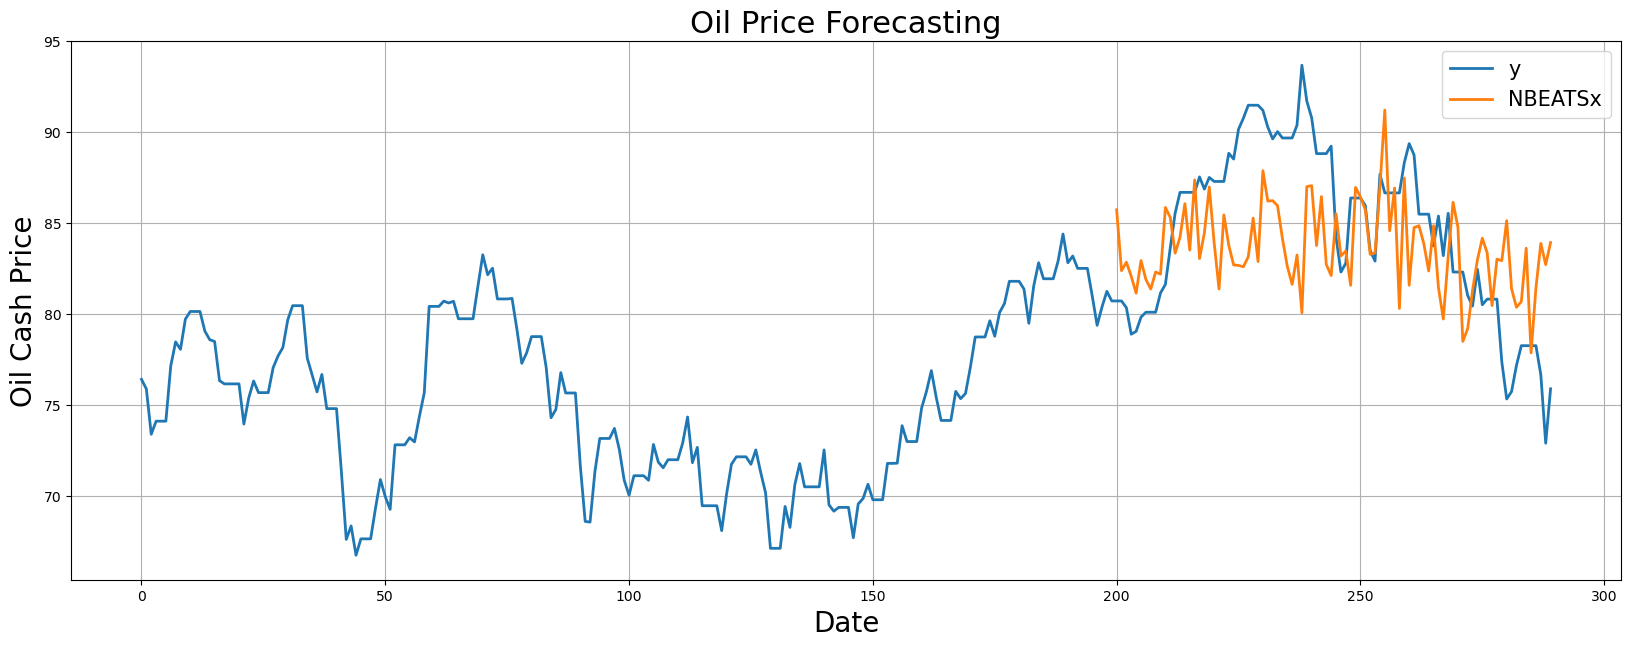

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
preds_cov_[['y', 'NBEATSx']].plot(ax=ax, linewidth=2)
ax.set_title('Oil Price Forecasting', fontsize=22)
ax.set_ylabel('Oil Cash Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# Conlcusion:
# NBEATSx model with ^DJI and ^VIX as convariates yields the best forecasting performance